# PVD inversion

PVD and Vph inversion approaches will be applied on measured data in MUSC laboratory. 

Inversion algorithm: Neighborhood Algorithm (Sambridge (1999a, 1999b),  Wathelet (2008))

Data used: C0 model measured at the top line, data obtained in MUSC (02/2019)

## 1. Open SU data

Measured seismogram for C0 model. Original data are filtered by SU (sufilter f=10,15,150,200 amps=0,1,1,0) to reduce Vph oscillation.

In [27]:
# open SU file
from nessi.io import suread

#-> file name
filename = "data/C0_filter_100kHz.su"

#-> Scan SU data, traces + headers
data = suread(filename)

In [33]:
# read information from the SU data

import numpy as np
#-> seismogram 
dobs = data.copy()
trace = dobs.traces # amplitude of each trace
trace = trace[1:, :].T # transpose matrix

#-> ns: sampling number; ntraces: number of traces
ns, ntraces = trace.shape

#-> time
dt = dobs.header[0]['dt']/1e6
t = np.linspace(0, (ns-1)*dt, ns)

#-> offset
dx = 1 # receiver space
offset = 12 # source to the first receiver space
x = np.linspace(offset, (ntraces-1)*dx+offset, ntraces)

## 2. Data processing

Calculate measured dispersion diagram and dispersion curve of C0 model.

(71,) (71,) (551, 71)


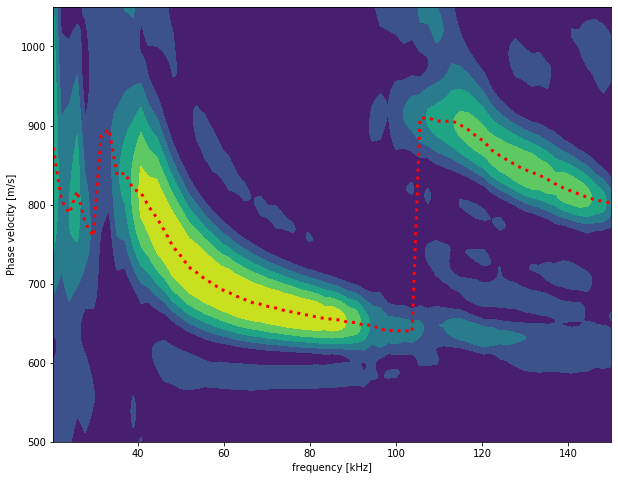

In [39]:
from math_func import diagram_v_f

#-> frequancy and velocity ranges
fmin = 20; fmax = 150
vmin = 500; vmax = 1050; nv = 551
v = np.linspace(vmin, vmax, nv)

#-> phase-shift method
f, vph, diagram = diagram_v_f(trace, x, t, fmin, fmax, vmax, vmin, nv)

#-> plot dispersion diagram and curves
plt.figure(figsize = [10, 8])
plt.xlabel("frequency [kHz]"); plt.ylabel("Phase velocity [m/s]")
plt.plot(f, vph, linewidth = 3, linestyle = ":", color = "r")
plt.contourf(f, v, diagram)

## 3. PVD dispersion curve calculation

PVD can be calculated using an analytical equation (Wang 2020) or Vph gradient with respect to frequency. Here is an example using theoretical Vph and Vg dispersion curves of a given model. 

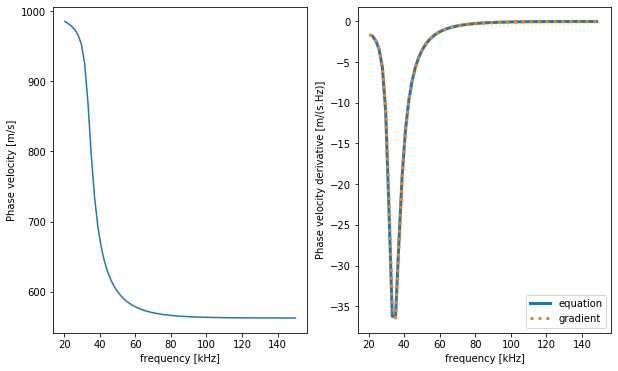

In [67]:
#-> model parameters
thk = np.array([8.0, 0], dtype = float) # the third layer is semi-infinite, thickness = 0 by default
dns = np.array([450, 1300], dtype = float) # density
cvp = np.array([1300, 2048], dtype = float) # P-wave
cvs = np.array([600.0, 1100.0], dtype = float) # S-wave

#-> theoretical Vph and Vg
vph_theor = 1/(gpdc_calculation(f, cvp, cvs, dns, thk)[:,1])
vg_theor = 1/(gpdc_calculation(f, cvp, cvs, dns, thk, 1, "group")[:,1])

#-> PVD
dvph_eq = vph_theor[1:-1]*(vg_theor-vph_theor[1:-1])/(f[1:-1]*vg_theor) # calculated by equation
dvph_grad = np.gradient(vph_theor, f) # calculated by frequency gradient

#-> plot

fig, ax = plt.subplots(1,2, figsize = [10,6])
plt.setp(ax, xlabel="frequency [kHz]")
plt.setp(ax[0], ylabel="Phase velocity [m/s]")
plt.setp(ax[1], ylabel="Phase velocity derivative [m/(s.Hz)]")

ax[0].plot(f, vph_theor)

ax[1].plot(f[1:-1], dvph_eq, label = "equation", linewidth = 3)
ax[1].plot(f, dvph_grad, linestyle = ":", label = "gradient", linewidth = 3)
plt.legend()

Two PVD curves are identical when using theoreticla dispersion curves. When using the measured data, we use the gradient method to extract PVD curve because of the difficulty of Vg extraction with high precision.

## 4. Vph inversion

Four parameters are needed for the NA inversion: ni, n0, n1, n2. Those parameters are the same for Vph and PVD inversions. 

Parameter space are ranged by "mmin" and "mmax", of which the length equals to Nlayer*Nparam-1, with Nlayer being the number of layers, Nparam being the number of searched parameters. For example, in our case, Nlayer = 2, Nparam = 2 (we are looking for Vs and thickness, Vp and density are fixed), the length of mmin and mmax equals to 3.

Frequency zone for Vph and PVD inversion is [35, 90]kHz to avoid noise at low frequencies and mode jupm at high frequencies.

In [69]:
#-> inversion parameters
ni=15       # number of iterations
n0=20       # number of initial random model samples
n1=10       # number of best models used at each iteration
n2=10       # number of new models in the neighborhood of previous best models

#-> parameter space
mmin = np.asarray([500, 800, 7.0]) # Vs1, Vs2, thk
mmax = np.asarray([900, 1200, 8.0])

#-> frequency range for inversion
f_begin = 35; f_end = 90
findex = (f>=f_begin)&(f<=f_end)
finv = f[findex]

Inversion results are given by mo (inverted models arranged in increasing order of misfit values), Pmo (misfit values arranged in increasing order), pchrono (misfit values arranged as function of iteration number/time).

Measurement uncertainty can be included in the Vph inversion. In the case where the error is not available, it can be replaced by inversion input data (Vph for Vph inversion).

Attention: Vs range should be verified with Vp value (Poisson's ratio), or no dispersion curve will be calculated (lenth of Vph equals to 0).

In [71]:
from NA_inversion import vph_inversion

#-> Vph inversion
mo,Pmo,pchrono = vph_inversion(vph[findex],vph[findex],mmin,mmax,ni,n0,n1,n2,dns,cvp,finv)

print("Total number of inverted models = ", Pmo.shape)
print("Inverted model matrix's size = ", mo.shape)


[ 557.97483525 1011.67401971    7.76384075]
[841.80469114 913.02823019   7.49426703]
[633.52770017 925.71671942   7.35746608]
[660.61017867 974.66475886   7.46665865]
[ 601.05467837 1055.69687282    7.44837173]
[771.79900161 886.24057026   7.4073344 ]
[839.00845523 881.88096624   7.99937715]
[ 621.3904968  1130.32238559    7.82574049]
[ 845.44386147 1058.06204255    7.70281729]
[ 801.68932356 1156.62034474    7.1532289 ]
[705.41577454 805.39692245   7.47107421]
[691.79055966 852.84661853   7.56376744]
[ 664.05954129 1102.86402583    7.62562792]
[ 807.52877565 1136.38023511    7.39804632]
[ 771.16971429 1000.90384578    7.98327101]
[ 677.5090684  1108.93544927    7.19026661]
[ 547.23083959 1053.83535975    7.85950072]
[899.66056074 803.67340617   7.06004523]
[ 567.11707722 1196.28831714    7.35674854]
[ 873.78174299 1024.59925885    7.59438986]
[ 882.15764587 1000.20048279    7.99735079]
[853.7335851  863.91368839   7.98352501]
[795.61603479 922.89953201   7.85473945]
[820.52993107 950.

[702.52092549 995.03303676   7.18868549]
[690.18011587 957.65881916   7.16583307]
[691.16233907 945.76910015   7.21020652]
[691.15375841 956.12897915   7.24417778]
[ 695.02369741 1023.51708683    7.27278765]
[698.73446145 980.74611603   7.23510241]
[702.33894159 927.49004886   7.14049188]
[699.09078111 893.32286486   7.20236579]
[708.28907536 914.81723598   7.22754627]
[699.02713741 912.6831774    7.11919824]
[704.90172167 923.92352449   7.12659503]
[707.72705843 948.91535218   7.08669575]
[710.38610788 911.62200701   7.20083632]
[702.9933523  950.11853628   7.0967145 ]
[702.92941453 870.64112243   7.09833832]
[704.02528078 872.23590091   7.11344251]
[696.88621809 926.66759436   7.45257308]
[701.52644328 913.18750193   7.49886549]
[699.11063912 910.75546598   7.4756134 ]
[699.40050075 912.10914457   7.54198435]
[698.46532704 925.14471598   7.40962148]
[695.94128257 915.24094735   7.55730166]
[696.68477282 916.30312899   7.56513942]
[696.72813277 917.16804707   7.5316818 ]
[697.30774168

[698.95258974 926.06991766   7.18912399]
[699.34283326 925.04173811   7.22689348]
[699.70572127 925.73597959   7.25072709]
[699.1230509  932.0479363    7.25379193]
[697.96247852 925.60758093   7.27372218]
[698.441964   924.63688028   7.24311751]
[698.40075195 931.81134721   7.25835162]
[698.06204497 923.41021366   7.28937958]
[698.2096661  933.21806653   7.28050533]
[698.74297671 929.01775975   7.22533348]
[699.2425616  929.15506437   7.20284198]
[698.54737609 931.79807621   7.3124475 ]
[698.38695583 930.30671222   7.21699535]
[698.61050545 928.56784229   7.25542198]
[698.01136069 928.67864004   7.25100692]
[699.34632216 928.29386744   7.25483029]
[698.24514706 928.32599349   7.20385685]
[698.39876626 928.200401     7.22614971]
[698.03361341 928.29277947   7.25257063]
[699.1553274  929.44088115   7.23063574]
[699.03393221 928.54566721   7.24196622]
[698.28652383 928.39029886   7.23951223]
[698.37333332 929.00075843   7.26299207]
[699.9749183  931.49224345   7.22536261]
[699.5062139  93

[699.14296357 928.20436721   7.26535091]
[699.36777448 928.62795324   7.26723191]
[699.20500898 927.42206867   7.26280181]
[699.27578052 927.61749277   7.26961014]
[699.5677174  928.4504042    7.27232502]
[699.59497585 927.90686033   7.2658373 ]
[699.26563334 927.57373553   7.26565221]
[699.15003289 927.7445852    7.26487913]
[699.24334954 927.90082221   7.26476699]
[699.48392133 927.96046047   7.26375971]
[699.59629327 927.70921442   7.2589213 ]
[699.52449827 927.64434751   7.27246814]
[699.34965099 928.85605296   7.26560633]
[699.39844787 929.02998892   7.26623787]
[699.37588672 928.66467225   7.27061231]
[699.37124743 929.06657158   7.27143621]
[699.30184492 928.85987589   7.26444435]
[699.29328947 928.78478249   7.27250713]
[699.22087576 928.59647892   7.26913823]
[699.40470067 928.90641443   7.27195699]
[699.35871538 928.39832892   7.26959827]
[699.28995104 928.86984336   7.26610041]
[699.46005033 928.6348974    7.27507477]
[699.66439917 928.54056515   7.27171761]
[699.62748418 92

[699.66207723 930.08641926   7.28329857]
[699.64811907 930.0634319    7.28524217]
[699.57495992 929.91178425   7.28558232]
[699.65251762 930.13865954   7.28736168]
[699.46340176 930.01130434   7.28777405]
[699.53290105 930.04058491   7.2886115 ]
[699.45628126 930.02683143   7.28878937]
[699.52325678 929.9634454    7.28810978]
[699.55519445 929.90541085   7.28899715]
[699.54804385 929.89988534   7.28728107]
[699.54426895 930.05239825   7.28743716]
[699.51953512 929.9715855    7.28806551]
[699.51121896 929.87896458   7.28762061]
[699.51673156 929.96050228   7.28862057]
[699.62472166 930.31757363   7.28984434]
[699.64686846 930.24595993   7.2900665 ]
[699.64575456 930.38588095   7.29129778]
[699.65159786 930.42622448   7.29084754]
[699.65609785 930.31686261   7.29067219]
[699.64984476 930.3757587    7.2898206 ]
[699.64668818 930.31170955   7.29080888]
[699.68267076 930.32916266   7.29097902]
[699.61345057 930.31425114   7.2905368 ]
[699.6871728  930.30249303   7.2904163 ]
[699.78890216 93

[699.70425626 929.98769783   7.29002257]
[699.70094713 930.01353047   7.29021204]
[699.7031218  929.99242324   7.28995323]
[699.70130057 929.9990078    7.29035583]
[699.69495412 929.99963754   7.29052577]
[699.70311163 929.97704607   7.29056525]
[699.72108266 930.1448085    7.29150216]
[699.72583912 930.16672508   7.29239994]
[699.74179934 930.18058663   7.29163144]
[699.74313632 930.16908253   7.29191068]
[699.73574817 930.1547874    7.2915653 ]
[699.73600004 930.14250891   7.29167619]
[699.7350192  930.19294452   7.29208831]
[699.75042289 930.20151147   7.29254394]
[699.75002027 930.20033613   7.29198128]
[699.74166988 930.13890683   7.29171654]
[699.71095631 930.08029049   7.29055023]
[699.7072933  930.06995943   7.29031053]
[699.70630766 930.06199618   7.29039156]
[699.71910578 930.09795143   7.29033782]
[699.72136621 930.08981362   7.29026809]
[699.71769758 930.0764816    7.29053103]
[699.7037598  930.08197316   7.29049502]
[699.71768448 930.07957865   7.29059595]
[699.70612266 93

[699.74060049 930.17083578   7.29259031]
[699.7388667  930.11170611   7.2918831 ]
[699.74133247 930.09557305   7.29218339]
[699.7412107  930.09608871   7.29208511]
[699.74799204 930.10979474   7.29202688]
[699.74641848 930.0991744    7.29182982]
[699.74096778 930.09796316   7.2917741 ]
[699.74174322 930.09887281   7.29189665]
[699.73957397 930.10941589   7.29184175]
[699.73974009 930.09462527   7.29198066]
[699.74746646 930.09263412   7.29199814]
[699.74378779 930.11939044   7.29272235]
[699.74510457 930.11732173   7.29287077]
[699.7472782  930.11833118   7.29283352]
[699.74190871 930.11433306   7.29278902]
[699.74339753 930.11962792   7.292925  ]
[699.74525188 930.1223971    7.29274875]
[699.74769068 930.13159203   7.29283343]
[699.74419479 930.11584763   7.29281626]
[699.74177451 930.12112035   7.29287158]
[699.74179971 930.1105818    7.29281994]
[699.73904402 930.11964689   7.29252294]
[699.73232934 930.11948565   7.29264612]
[699.73572241 930.12113803   7.29250278]
[699.73237454 93

[699.74014604 930.12213093   7.29225466]
[699.7399751  930.12474508   7.29227085]
[699.73968571 930.12314616   7.29225311]
[699.74024077 930.12189991   7.29227786]
[699.7398917  930.12173156   7.29230321]
[699.74348517 930.11927546   7.29238937]
[699.74372773 930.11965292   7.29238886]
[699.74333338 930.11873166   7.29233396]
[699.74197339 930.11974651   7.29233804]
[699.74181122 930.11815101   7.29234323]
[699.74112645 930.11781606   7.29235692]
[699.74329324 930.11787437   7.29235779]
[699.743455   930.11900249   7.29239352]
[699.74329639 930.11899237   7.29234406]
[699.74186081 930.11958304   7.29234935]
[699.73676609 930.11827545   7.29225215]
[699.73828864 930.11706008   7.29225042]
[699.73691743 930.11928699   7.29226049]
[699.73789005 930.11947477   7.29221742]
[699.73795565 930.12285821   7.29219065]
[699.73777135 930.12303246   7.29220834]
[699.73762198 930.1198725    7.29220609]
[699.73717892 930.12060575   7.29223123]
[699.73719853 930.12201876   7.29222688]
[699.73786498 93

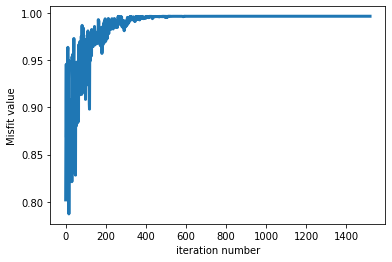

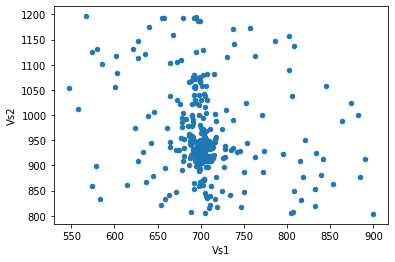

In [74]:
plt.figure()
plt.xlabel("iteration number"); plt.ylabel("Misfit value")
plt.plot(pchrono, linewidth = 3)


plt.figure()
plt.xlabel("Vs1"); plt.ylabel("Vs2")
plt.scatter(mo[:,0], mo[:,1], s = 20)

## 5. PVD inversion

PVD dispersion curve is calculated using the Vph gradient with respect to frequency. 

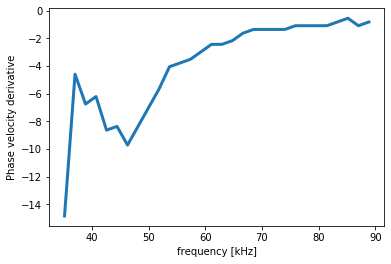

In [77]:
dvph = np.gradient(vph, f)[findex]

plt.figure()
plt.xlabel("frequency [kHz]"); plt.ylabel("Phase velocity derivative")
plt.plot(finv, dvph, linewidth = 3)

Combined data are made by Vph at low (f<=42) and high (f>=70) frequancies and PVD at medium frequency.

In [79]:
# frequency raneg for combined data
f1 = 42; f2 = 70

#-> combined data
inv_data = dvph.copy()
inv_data[finv<=f1] = vph[(f>=f_begin)&(f<=f1)]
inv_data[finv>=f2] = vph[(f>=f2)&(f<=f_end)]

In [81]:
from NA_inversion import complex_inversion

#-> PVD inversion
mo_com,Pmo_com,pchrono_com = complex_inversion(inv_data[1:-1],inv_data[1:-1],mmin,mmax,ni,n0,n1,n2,dns,cvp,finv, f1, f2) 

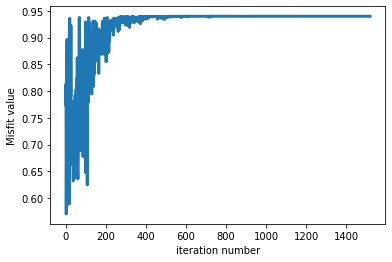

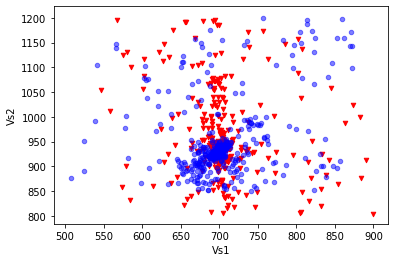

In [86]:
plt.figure()
plt.xlabel("iteration number"); plt.ylabel("Misfit value")
plt.plot(pchrono_com, linewidth = 3)


plt.figure()
plt.xlabel("Vs1"); plt.ylabel("Vs2")
plt.scatter(mo[:,0], mo[:,1], s = 20, color = "red", marker = "v")
plt.scatter(mo_com[:,0], mo_com[:,1], s = 20, color = "blue", marker = "o", alpha = 0.5)

## References

Sambridge, M. (1999a). Geophysical inversion with a neighbourhood algorithm - i. searching a parameter space.
Geophysical journal international, 138(2):479-494.

Sambridge, M. (1999b).Geophysical inversion with a neighbourhood algorithm - ii. appraising the ensemble. Geophysical Journal International, 138(3):727-746.

Wathelet, M. (2008). An improved neighborhood algorithm: parameter conditions and dynamic scaling. Geophysical Research Letters, 35(9).

Wang, A., Leparoux, D., Abraham, O., and Le Feuvre, M. (2020b). Frequency derivative of rayleigh wave phase velocity for fundamental mode dispersion inversion: parametric study and experimental application.Geophysical Journal International.